# Facial Detection and Data Generation

In [1]:
# import the necessary packages
from imutils import face_utils
import numpy as np
#import argparse
import imutils
import dlib
import cv2
import multiprocessing
from multiprocessing import Pool
import glob
import os
import pandas as pd
import re
import pickle
from shutil import rmtree
from landmarks import landmarks_convert
from combine import deep_convert
#from googlevision import google_convert
import random

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
#image = input("input img url:")

In [4]:
image = "../../IPMD/img_data/New Training Data as of 0714 2018/"

In [5]:
def convert_single_img(input_img):
    try:
        temp_out = deep_convert(input_img, pic_id = 0, return_rectangle = True, save_img=False)
    except:
        print("fail to find the front face")
    return temp_out

In [6]:
def image_shown(image):
    """
    CV2 package use BGR, matplotlib use RGB
    """
    try:
        temp_out = convert_single_img(image)
    except:
        None
    img = cv2.imread(image)
    left, right, up, down = temp_out[1][0:4]
    green = (0, 255, 0)
    cv2.rectangle(img, (left, up), (right, down), green)
    cv2.imwrite("outputimage.jpg", img)
    img=mpimg.imread("outputimage.jpg")
    plt.imshow(img)

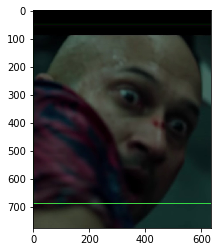

In [7]:
image_shown(image)

In [8]:
test_img_data = convert_single_img(image)[0].reshape(200,200)

In [9]:
# convert np data type into int data type for json

push_data = []
for i in test_img_data:
    row = []
    for j in i:
        row.append([int(j)])
    push_data.append(row)
"""
for i in test_img_data:
    push_data.append(int(i))
"""


'\nfor i in test_img_data:\n    push_data.append(int(i))\n'

In [10]:
push_data_np = np.array(push_data)

In [34]:
# need a 1*200*200*1 input
push_data_np.shape

(200, 200, 1)

# Use Rest API to Get Prediction

In [12]:
import requests
import json

In [45]:
url = "http://35.224.178.33:8501/v1/models/my_model/versions/1"

In [46]:
r = requests.get(url)
print (r)

<Response [404]>


In [82]:
# convert data into json
data = {"instances":[push_data],
       "signature_name": "predictions"}

push_data_json = json.dumps(data, sort_keys=True, separators=(',', ': '))

"""
with open('data.json', 'w') as outfile:
    json.dump(push_data_json, outfile)
"""
# print(push_data_json)

{"instances": [[[[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]],[[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[

In [83]:
# requests via REST API
r = requests.post("http://35.224.178.33:8501/v1/models/my_model:predict", data=push_data_json)
print(r.text)

{ "error": "Serving signature name: \"Predictions\" not found in signature def" }
